## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import urllib.request

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("../../")
import toolkit as tk
sys.path.append("../../Team_Challenge_SP10_T03")
import toolbox_ML as tb

## Datos

In [3]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle de train

df_train = pd.read_csv("data/train.csv", index_col=0)
df_train.index.name = None

In [4]:
df_train.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


## Exploración de los datos

In [5]:
# Comprobamos si hay duplicados

df_train.duplicated(keep = False).value_counts()

False    877
True      35
Name: count, dtype: int64

*Tenemos un 4% de duplicados. Los vamos a mantener ya que podría darse el caso de tener ordenadores con las mismas características y mismo precio*

In [6]:
tb.describe_df(df_train).T

,DATE_TYPE,MISSINGS(%),UNIQUE_VALUES,CARDIN(%)
COL_N,,,,
Company,object,0.0,19,2.08
Product,object,0.0,480,52.63
TypeName,object,0.0,6,0.66
Inches,float64,0.0,17,1.86
ScreenResolution,object,0.0,36,3.95
Cpu,object,0.0,107,11.73
Ram,object,0.0,9,0.99
Memory,object,0.0,37,4.06
Gpu,object,0.0,93,10.2


In [7]:
tb.tipifica_variables(df_train)

,nombre_variable,dtype,tipo_sugerido
0,Company,object,Numerica discreta
1,Product,object,Numerica continua
2,TypeName,object,Categorica
3,Inches,float64,Numerica discreta
4,ScreenResolution,object,Numerica discreta
5,Cpu,object,Numerica discreta
6,Ram,object,Categorica
7,Memory,object,Numerica discreta
8,Gpu,object,Numerica discreta
9,OpSys,object,Categorica


In [8]:
df_train_1 = df_train.copy()

In [9]:
df_train_1["Inches_num"] = df_train_1["Inches"]
df_train_1["Weight_kg"] = df_train_1["Weight"].str.replace("kg", "").astype(float)
df_train_1["Ram_gb"] = df_train_1["Ram"].str.replace("GB", "").astype(float)

In [ ]:



*Weight = Numérica continua*
*Price_in_euros = Target*

In [7]:
target = "Price_in_euros"

In [13]:
df_train["Weight"].value_counts(True)

Weight
2.2kg     0.099781
2.1kg     0.043860
2.4kg     0.033991
2.5kg     0.031798
2.3kg     0.029605
            ...   
0.91kg    0.001096
2.15kg    0.001096
2.54kg    0.001096
1.18kg    0.001096
4.33kg    0.001096
Name: proportion, Length: 165, dtype: float64

In [9]:
# features_cat_reg = ["TypeName"]

In [66]:
features_cat_reg = ["TypeName", "Company"]

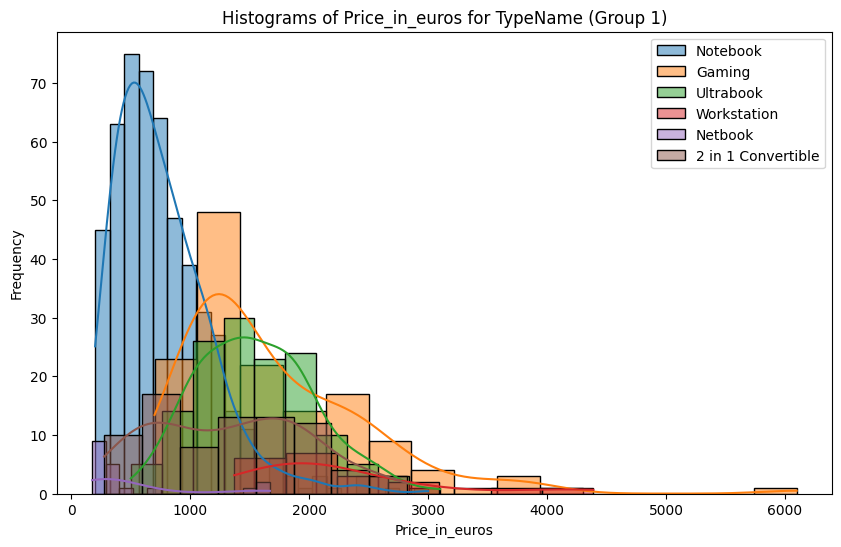

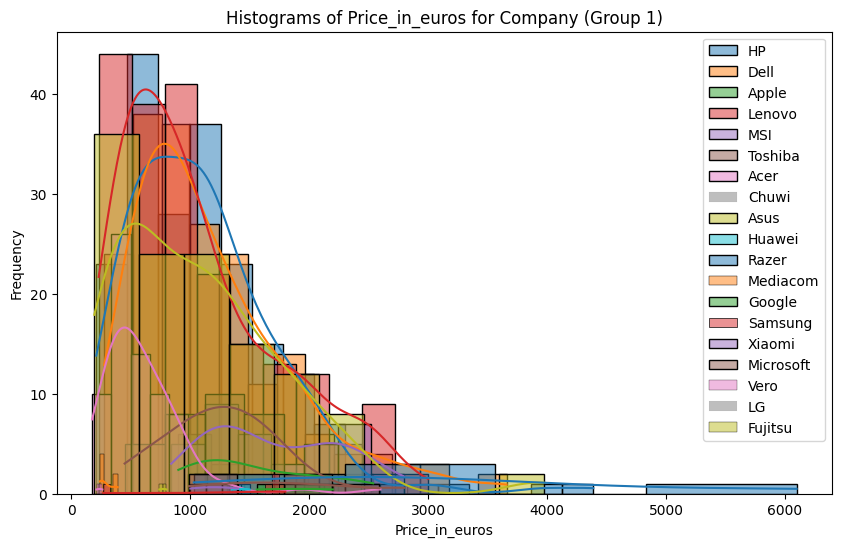

In [67]:
for i in range(len(features_cat_reg)):
    tk.plot_grouped_histograms(df_train, features_cat_reg[i], target, 20)

*Con la variable "TypeName" se puede sacar bastante información para la predicción. Vamos a hacerle un One-Hot-Encoding*

In [13]:
df_train_1 = pd.get_dummies(df_train_1, columns = features_cat_reg, dtype = int)

In [14]:
df_train_1.head()

,Company,Product,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation
755,HP,250 G6,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00,0,0,0,1,0,0
618,Dell,Inspiron 7559,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01,0,1,0,0,0,0
909,HP,ProBook 450,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00,0,0,0,1,0,0
2,Apple,Macbook Air,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,0,0,0,0,1,0
286,Dell,Inspiron 3567,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00,0,0,0,1,0,0


In [16]:
features = ["TypeName_2 in 1 Convertible", "TypeName_Gaming", "TypeName_Netbook", "TypeName_Notebook", "TypeName_Ultrabook", \
            "TypeName_Workstation", "Inches_num", "Weight_kg", "Ram_gb"]

In [17]:
df_train_1[features].describe()

,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,Inches_num,Weight_kg,Ram_gb
count,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000
mean,0.087719,0.156798,0.020833,0.558114,0.154605,0.021930,14.981579,2.026937,8.263158
std,0.283041,0.363810,0.142905,0.496884,0.361726,0.146535,1.436719,0.665466,5.044788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.100000,0.690000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,1.490000,4.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.600000,2.040000,8.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.600000,2.300000,8.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.400000,4.700000,64.000000


In [18]:
scaler = StandardScaler()

scaler.fit(df_train_1[features])

StandardScaler()

In [19]:
df_train_1[features] = scaler.transform(df_train_1[features])

In [20]:
df_train_1[features].describe()

,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,Inches_num,Weight_kg,Ram_gb
count,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02
mean,2.532088e-17,9.154471e-17,1.801678e-17,3.895519e-18,4.869399e-17,2.239924e-17,1.351745e-15,2.629476e-16,-6.427607e-17
std,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00,1.000549e+00
min,-3.100868e-01,-4.312259e-01,-1.458650e-01,-1.123845e+00,-4.276440e-01,-1.497382e-01,-3.399592e+00,-2.010126e+00,-1.242192e+00
25%,-3.100868e-01,-4.312259e-01,-1.458650e-01,-1.123845e+00,-4.276440e-01,-1.497382e-01,-6.835837e-01,-8.073019e-01,-8.455256e-01
50%,-3.100868e-01,-4.312259e-01,-1.458650e-01,8.898025e-01,-4.276440e-01,-1.497382e-01,4.306761e-01,1.963987e-02,-5.219294e-02
75%,-3.100868e-01,-4.312259e-01,-1.458650e-01,8.898025e-01,-4.276440e-01,-1.497382e-01,4.306761e-01,4.105578e-01,-5.219294e-02
max,3.224903e+00,2.318970e+00,6.855655e+00,8.898025e-01,2.338394e+00,6.678323e+00,2.380631e+00,4.019031e+00,1.105446e+01


## Procesado de datos

Nuestro target es la columna `Price_in_euros`

-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [21]:
# X = df.drop[target, axis=1]
X = df_train_1[features].copy()
y = df_train_1[target].copy()
X.shape

(912, 9)

In [22]:
X.shape

(912, 9)

In [23]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [25]:
X_train

,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,Inches_num,Weight_kg,Ram_gb
1118,-0.310087,-0.431226,-0.145865,-1.123845,-0.427644,6.678323,1.614577,1.463029,-0.052193
153,-0.310087,2.318970,-0.145865,-1.123845,-0.427644,-0.149738,0.430676,0.801476,1.534472
275,-0.310087,-0.431226,-0.145865,-1.123845,2.338394,-0.149738,-1.171072,-0.987726,-0.052193
1100,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,-0.683584,-0.732125,-0.845526
131,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,1.614577,1.162323,1.534472
...,...,...,...,...,...,...,...,...,...
578,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,-0.683584,-0.130713,-0.052193
996,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,0.430676,0.260205,-0.448859
770,-0.310087,-0.431226,-0.145865,-1.123845,2.338394,-0.149738,-1.728202,-1.273396,1.534472
407,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,0.430676,0.260205,-0.845526


In [26]:
y_train

1118    2899.00
153     1249.26
275     1958.90
1100    1030.99
131     1396.00
         ...   
578      389.00
996      549.00
770     1859.00
407      306.00
418     1943.00
Name: Price_in_euros, Length: 729, dtype: float64

### 3. Baseline de modelos


In [27]:
# model = RandomForestRegressor(n_estimators=100, random_state=42) # Baseline
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)

In [28]:
model_names_reg = ["Regresion Lineal", "DecisionTree", "Random Forest", "XGBoost", "LightGBM"]

lr_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state= 42)
rf_reg = RandomForestRegressor(random_state= 42)
xgb_reg = XGBRegressor(random_state = 42)
lgb_reg = LGBMRegressor(random_state= 42, verbose = -100)

model_set_reg = [lr_reg, tree_reg, rf_reg, xgb_reg, lgb_reg]

In [29]:
metricas_cv = {}
valores = []

for nombre, modelo in zip(model_names_reg, model_set_reg):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "neg_root_mean_squared_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "neg_root_mean_squared_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
DecisionTreeRegressor(random_state=42)
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
LGBMRegressor(random_state=42, verbose=-100)


In [30]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {-np.mean(valores)}")
print("--------------------")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, RMSE_CV: 391.2897121942616
Model <DecisionTree>, RMSE_CV: 391.03403049710886
Model <Random Forest>, RMSE_CV: 345.8956182542155
Model <XGBoost>, RMSE_CV: 373.44559939737155
Model <LightGBM>, RMSE_CV: 363.0958506382707
--------------------
El ganador es Random Forest


In [ ]:
# params_grid = {
#     "n_estimators": [100,200,400],
#     "max_depth": [2,4,10],
#     "min_samples_leaf": [10,20,40],
#     "max_features": ["sqrt","log2",None],
#     "max_samples": [0.3,0.6,1]
# }

# rf_grid = GridSearchCV(rf_reg,
#                        param_grid= params_grid,
#                        cv = 5,
#                        scoring = "root_mean_squared_error",
#                        n_jobs = -1)

# rf_grid.fit(X_train, y_train)

c:\Users\ancar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# rf_grid.best_score_

np.float64(-395.0956765801692)

In [ ]:
# rf_grid.best_params_

{'max_depth': 10,
 'max_features': None,
 'max_samples': 0.6,
 'min_samples_leaf': 10,
 'n_estimators': 200}

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

*Errores superiores a 400 son suspensos*

In [34]:
# rmse = root_mean_squared_error(y_val, y_pred) # Baseline
# rmse # Error obtenido con el modelo base = 477.031

In [35]:
rmse = -np.mean(metricas_cv["Random Forest"].tolist())

In [36]:
rmse

np.float64(345.8956182542155)

In [37]:
model = rf_reg

In [38]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [39]:
X_pred = pd.read_csv("data/test.csv", index_col=0)
X_pred.index.name = None
X_pred.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [40]:
X_pred = pd.get_dummies(X_pred, columns = features_cat_reg, dtype = int)

In [41]:
X_pred["Inches_num"] = X_pred["Inches"]
X_pred["Weight_kg"] = X_pred["Weight"].str.replace("kg", "").astype(float)
X_pred["Ram_gb"] = X_pred["Ram"].str.replace("GB", "").astype(float)

In [42]:
X_pred[features] = scaler.transform(X_pred[features])

In [43]:
X_pred.tail()

,Company,Product,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,Inches_num,Weight_kg,Ram_gb
820,MSI,GE72MVR 7RG,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg,-0.310087,2.318970,-0.145865,-1.123845,-0.427644,-0.149738,1.614577,1.312676,1.534472
948,Toshiba,Tecra Z40-C-12X,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,-0.683584,-0.837373,-0.845526
483,Dell,Precision M5520,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg,-0.310087,-0.431226,-0.145865,-1.123845,-0.427644,6.678323,0.430676,-0.371278,-0.052193
1017,HP,Probook 440,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,-0.683584,-0.581772,-0.845526
421,Asus,ZenBook Flip,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.27kg,3.224903,-0.431226,-0.145865,-1.123845,-0.427644,-0.149738,-1.171072,-1.138079,-0.052193


In [44]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Company                      391 non-null    object 
 1   Product                      391 non-null    object 
 2   Inches                       391 non-null    float64
 3   ScreenResolution             391 non-null    object 
 4   Cpu                          391 non-null    object 
 5   Ram                          391 non-null    object 
 6   Memory                       391 non-null    object 
 7   Gpu                          391 non-null    object 
 8   OpSys                        391 non-null    object 
 9   Weight                       391 non-null    object 
 10  TypeName_2 in 1 Convertible  391 non-null    float64
 11  TypeName_Gaming              391 non-null    float64
 12  TypeName_Netbook             391 non-null    float64
 13  TypeName_Notebook      

 ## 2. Replicar el procesado para ``test.csv``

In [45]:
X_pred

,Company,Product,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation,Inches_num,Weight_kg,Ram_gb
209,Lenovo,Legion Y520-15IKBN,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg,-0.310087,2.318970,-0.145865,-1.123845,-0.427644,-0.149738,0.430676,0.560911,1.534472
1281,Acer,Aspire ES1-531,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,0.430676,0.560911,-0.845526
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,0.430676,-0.190854,-0.845526
1231,Dell,Inspiron 7579,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg,3.224903,-0.431226,-0.145865,-1.123845,-0.427644,-0.149738,0.430676,0.246673,-0.052193
1020,HP,ProBook 640,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,-0.683584,-0.115678,-0.845526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,GE72MVR 7RG,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg,-0.310087,2.318970,-0.145865,-1.123845,-0.427644,-0.149738,1.614577,1.312676,1.534472
948,Toshiba,Tecra Z40-C-12X,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,-0.683584,-0.837373,-0.845526
483,Dell,Precision M5520,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg,-0.310087,-0.431226,-0.145865,-1.123845,-0.427644,6.678323,0.430676,-0.371278,-0.052193
1017,HP,Probook 440,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg,-0.310087,-0.431226,-0.145865,0.889803,-0.427644,-0.149738,-0.683584,-0.581772,-0.845526


In [46]:
X_pred_features = X_pred[features].copy()

In [47]:
predictions_submit = model.predict(X_pred_features)
predictions_submit

array([1511.74214286,  408.34728359,  479.84250591,  846.67565685,
       1072.20233333,  639.68811   ,  768.15313113,  706.00424603,
       1081.40576667,  491.6799    , 2272.9651619 , 1679.64955238,
        498.91702489, 1447.4386    , 1057.47329762,  422.95580828,
       2283.73966667, 1468.67083333, 1677.36023556,  611.14429198,
       1433.6272    ,  414.40166667, 1106.23475595, 1662.71966667,
        477.24635667,  737.73460845, 1134.98071429,  883.31508333,
       2427.1937819 , 1088.41163167, 1844.92864714,  464.22551128,
       1406.96508036, 3238.63526833, 2077.0961    , 1986.9783759 ,
        624.35684917, 1394.74165404,  839.14513333, 1703.6725    ,
       1015.55131697, 1239.172087  ,  569.9677619 , 1088.41163167,
       1437.04484524, 1078.72893561,  922.83181607,  464.22551128,
        737.73460845,  469.97756311, 2169.8111    ,  737.73460845,
       1158.96332917,  642.90044777, 1820.74966667, 2027.73323556,
        590.50578942,  905.42242588, 1004.8488    ,  732.96738

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [48]:
# ¿Qué opináis?
# ¿Sí, no?

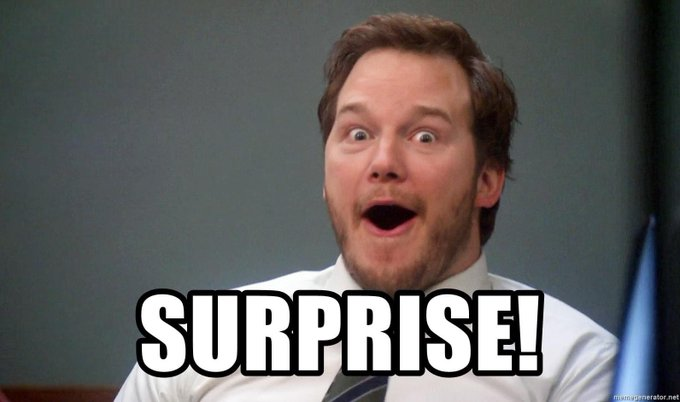

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [49]:
sample = pd.read_csv("data/sample_submission.csv")

In [50]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [51]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [52]:
X_pred_features.index

Index([ 209, 1281, 1168, 1231, 1020,  379,  553,  172,  779,  609,
       ...
         38, 1032, 1201,  646,  679,  820,  948,  483, 1017,  421],
      dtype='int64', length=391)

In [53]:
#¿Cómo creamos la submission?
submission = pd.DataFrame({"laptop_ID": X_pred_features.index, "Price_in_euros": predictions_submit})

In [54]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1511.742143
1,1281,408.347284
2,1168,479.842506
3,1231,846.675657
4,1020,1072.202333


In [55]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [56]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [57]:
chequeador(submission)

You're ready to submit!
